# Demo - RBIG

This is a tldr demonstration for how we can use RBIG to Gaussianize multivariate data, estimate probabilities and draw samples from our distribution.

In [1]:
import sys, os
from pyprojroot import here

# spyder up to find the root
root = here(project_files=[".here"])

# append to path
sys.path.append(str(here()))


# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", True)

import numpy as onp
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_joint, plot_joint_prob, plot_info_loss
from rbig_jax.models.rbig import IterativeGaussianization

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Data

We are going to generate a 2D dataset and plot the joint distribution.

<Figure size 432x288 with 0 Axes>

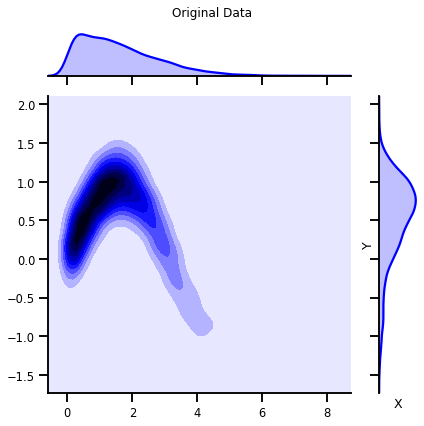

In [2]:
# %%wandb
# get data
data = get_classic(10_000)

# plot data
plot_joint(data, "blue", "Original Data", kind='kde', logger=False)

You can clearly see that this is not Gaussian; neither jointly nor marginally. Our objective is to use the RBIG algorithm to make this density jointly Gaussian or Gaussian.

### RBIG Object

RBIG works very similarly as an scikit-learn function. Meaning it follows the standard `transform`, `inverse_transform`, `predict_proba` and `score`.

### Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

In this first example, we're going to do a single RBIG transformation to see what happens.

In [3]:
from rbig_jax.models.rbig import RBIGStandard
# intialize Gaussianization transformation
max_layers = 1

# initialize rbig model
rbig_clf = RBIGStandard(
    n_samples=data.shape[0], 
    jitted=True, 
    max_layers=max_layers
)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [4]:
%%time
# fit rbig model
X = rbig_clf.fit_transform(data);

# check layers are the same
assert rbig_clf.n_layers == max_layers

CPU times: user 5.89 s, sys: 5.69 s, total: 11.6 s
Wall time: 4.3 s


In [5]:
%%time

# forward transform
X_trans = rbig_clf.transform(data)

CPU times: user 324 ms, sys: 6.01 ms, total: 330 ms
Wall time: 325 ms


<Figure size 432x288 with 0 Axes>

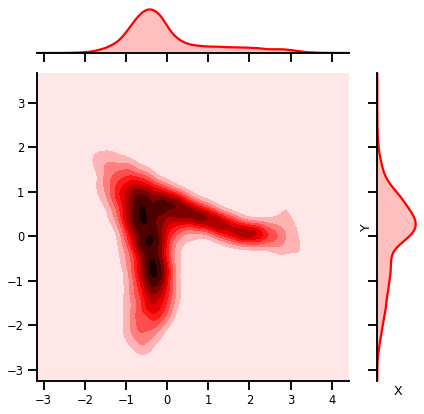

In [6]:
plot_joint(X_trans, kind="kde")

In [7]:
%%time 

# inverse transform
data_approx = rbig_clf.inverse_transform(X_trans)

# check that they're all close
chex.assert_tree_all_close(data_approx, data)

CPU times: user 450 ms, sys: 10.1 ms, total: 460 ms
Wall time: 446 ms


#### Adding More Layers

So this is nice because the inverse and the forward functions work. However, we can't predict and probability estimates nor can we sample without our latent space $Z$ being perfectly Gaussian (marginally and jointly). So we need to add more layers.

In [51]:
# intialize Gaussianization transformation
data = get_classic(10_000)
max_layers = 15

# initialize rbig model
rbig_clf = RBIGStandard(
    n_samples=data.shape[0], 
    jitted=True, 
    max_layers=max_layers
)

In [52]:
%%time

# fit rbig model
Xtrans = rbig_clf.fit_transform(data)

# check layers are the same
assert rbig_clf.n_layers == max_layers

CPU times: user 4.83 s, sys: 22.5 ms, total: 4.85 s
Wall time: 4.69 s


In [53]:
%%time

# forward transformation
X_trans = rbig_clf.transform(data)


CPU times: user 13.5 ms, sys: 6.38 ms, total: 19.9 ms
Wall time: 7.21 ms


<Figure size 432x288 with 0 Axes>

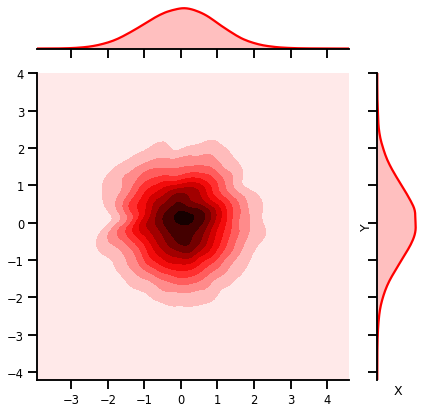

In [54]:
# plot results
plot_joint(X_trans, kind="kde")

Now our data is perfectly Gaussian. This means we can sample and we can also get probability estimates.

#### Inverse

In [55]:
%%time 

# inverse transform
data_approx = rbig_clf.inverse_transform(X_trans)

# check that they're all close
chex.assert_tree_all_close(data_approx, data)

CPU times: user 135 ms, sys: 31.2 ms, total: 166 ms
Wall time: 87.4 ms


#### Sample

In [56]:
%%time

# generate 10_000 random samples
data_samples = rbig_clf.sample(10_000)


CPU times: user 25.4 ms, sys: 9.11 ms, total: 34.5 ms
Wall time: 11.9 ms


<Figure size 432x288 with 0 Axes>

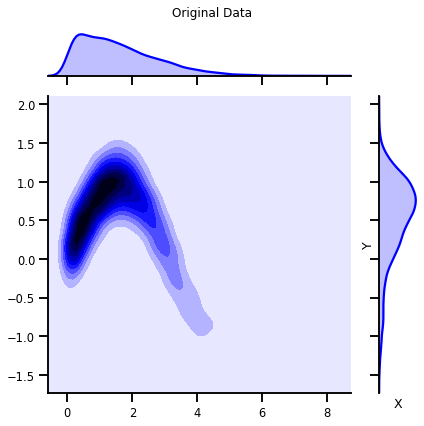

<Figure size 432x288 with 0 Axes>

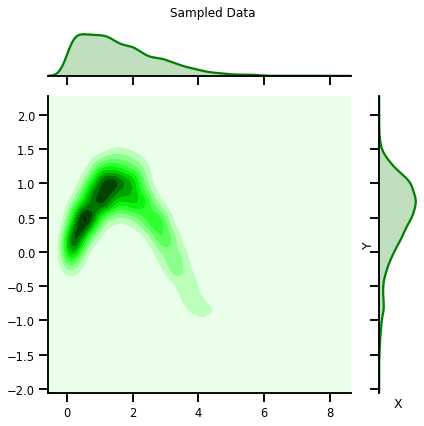

In [57]:
# plot samples
plot_joint(data, title="Original Data", color="blue", kind="kde")
plot_joint(data_samples,title="Sampled Data", color="green", kind="kde")

As you can see, our generate samples have a very similar distribution.

**note**: the more data you have to fit RBIG, the better samples you will generate.

### Stopping Criteria

Since this is an iterative technique, we need some sort of stopping criteria to know if we are fully Gaussian or not. In this method, we keep track of the marginal entropy between iterations. In theory, as the transformations make the data more and more Gaussian, there should be limited or no changes in the marginal entropy. We have an attribute called `info_loss` which keeps track of how much this has changed between iterations.

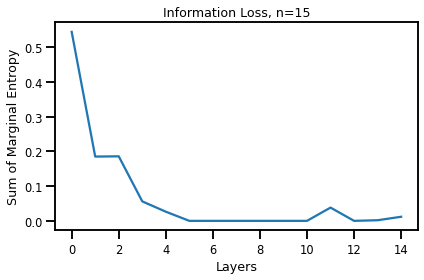

In [58]:
plot_info_loss(rbig_clf.info_loss, n_layers=rbig_clf.n_layers)

As we can see, there is effectively no change in the information loss after about 8 layers or so. So we can stop the iterative algorithm right then and there. We set the `tol_layers` to be roughly `10`. This means we will allow `10` layers of no changes before we stop the algorithm.  It's very similar to a callback. 

So let's rerun this algorithm with our helpful stopping criteria which encompasses this "callback".

In [59]:
rbig_clf.total_correlation(2)

DeviceArray(0.72818175, dtype=float64)

In [60]:
rbig_clf.entropy(data)

DeviceArray(0.58097081, dtype=float64)

In [61]:
rbig_clf.score(data)

DeviceArray(-1.38717095, dtype=float64)

### Density Estimation

In [62]:
%%time 

# inverse transform
X_lprob = rbig_clf.score_samples(data)

CPU times: user 83.5 ms, sys: 4.04 ms, total: 87.5 ms
Wall time: 31.9 ms


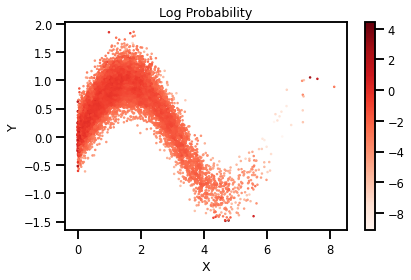

In [63]:
cmap = "Reds"
probs = X_lprob
# probs = np.clip(probs, 0.0, 1.0)
title = "Log Probability"

fig, ax = plt.subplots()
h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs,  cmap=cmap)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()

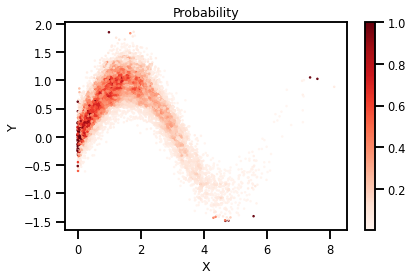

In [64]:
cmap = "Reds"
probs = np.exp(X_lprob)
probs = np.clip(probs, 0.0, 1.0)
title = "Probability"

fig, ax = plt.subplots()
h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs,  cmap=cmap)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()